# Analisis Perjalanan dan Pengaruh Cuaca

Sebuah perusahaan berbagi tumpangan (ride-sharing) baru yang diluncurkan di Chicago yang bernama Zuber ingin memahami pola perjalanan pada informasi yang tersedia. Perusahaan ingin mencari tahu preferensi penumpang dalam menggunakan layanan transportasi serta faktor eksternal pada perjalanan yaitu cuaca setempat. Untuk itu, perlunya menganalisis data dari kompetitor dan menguji hipotesis pengaruh cuaca terhadap frekuensi perjalanan.

Deskripsi data
Database yang memuat informasi perjalanan taksi di Chicago:

Tabel `neighborhoods`: data terkait wilayah di kota Chicago
- name: nama wilayah
- neighborhood_id: kode wilayah

Tabel `cabs`: data terkait taksi
- cab_id: kode kendaraan
- vehicle_id: ID teknis kendaraan
- company_name: nama perusahaan yang memiliki kendaraan

Tabel `trips`: data terkait perjalanan
- trip_id: kode perjalanan
- cab_id: kode kendaraan yang beroperasi
- start_ts: tanggal dan waktu perjalanan dimulai (waktu dibulatkan dalam satuan jam)
- end_ts: tanggal dan waktu perjalanan berakhir (waktu dibulatkan dalam satuan jam)
- duration_seconds: durasi perjalanan dalam satuan detik
- distance_miles: jarak perjalanan dalam satuan mil
- pickup_location_id: kode wilayah penjemputan
- dropoff_location_id: kode wilayah pengantaran

Tabel `weather_records`: data terkait cuaca
- record_id: kode catatan cuaca
- ts: tanggal dan waktu saat pencatatan cuaca dilakukan (waktu dibulatkan dalam satuan jam)
- temperature: suhu saat pencatatan cuaca dilakukan
- description: deskripsi singkat tentang kondisi cuaca, seperti "light rain" (hujan ringan) atau "scattered clouds" (berawan)

### Skema Tabel
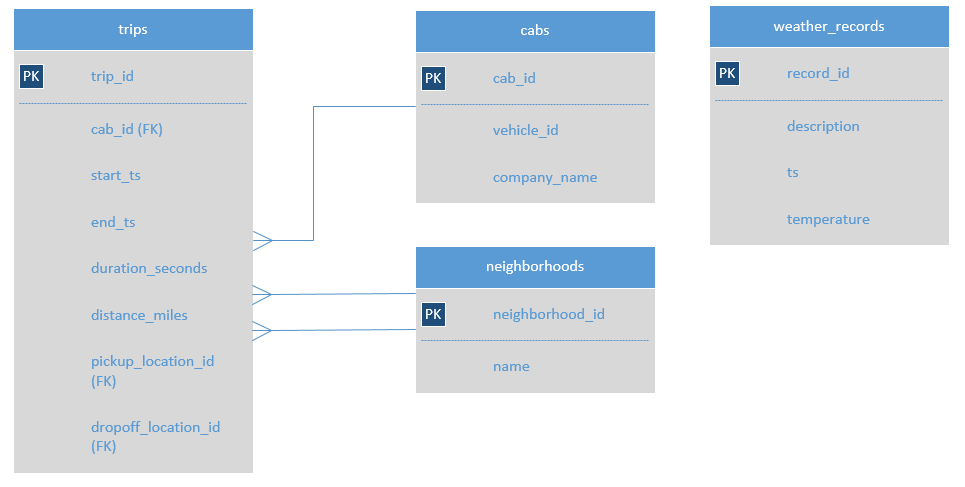

In [1]:
# Memuat semua library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st
from sqlalchemy import create_engine

import requests 
from bs4 import BeautifulSoup

## Penguraian Data
Pertama melakukan penguraian data dari website [Chicago Weather Records](https://practicum-content.s3.us-west-1.amazonaws.com/data-analyst-eng/moved_chicago_weather_2017.html). Nama DataFrame tersebut adalah weather_records dan harus menyebutkan secara spesifik saat mencarinya: attrs={"id": "weather_records"}

In [2]:
# mengirim permintaan ke server untuk mengurai situs web

URL = 'https://practicum-content.s3.us-west-1.amazonaws.com/data-analyst-eng/moved_chicago_weather_2017.html'
req = requests.get(URL)  # permintaan GET
soup = BeautifulSoup(req.text, 'lxml')

table = soup.find('table', attrs={"id": "weather_records"})

heading = []
for row in table.find_all('th'):
    heading.append(row.text)

content = []
for row in table.find_all('tr'):
    if not row.find_all('th'):
        content.append([element.text for element in row.find_all('td')])
    
weather_records = pd.DataFrame(content, columns=heading)
print(weather_records)

           Date and time Temperature       Description
0    2017-11-01 00:00:00     276.150     broken clouds
1    2017-11-01 01:00:00     275.700  scattered clouds
2    2017-11-01 02:00:00     275.610   overcast clouds
3    2017-11-01 03:00:00     275.350     broken clouds
4    2017-11-01 04:00:00     275.240     broken clouds
..                   ...         ...               ...
692  2017-11-29 20:00:00     281.340        few clouds
693  2017-11-29 21:00:00     281.690      sky is clear
694  2017-11-29 22:00:00     281.070        few clouds
695  2017-11-29 23:00:00     280.060      sky is clear
696  2017-11-30 00:00:00     278.460      sky is clear

[697 rows x 3 columns]


## Ekstrasi Data
Sebenarnya ekstrasi data dari database melalui platform digital TripleTen. Namun, tetap menulis kueri di notebook sebagai dokumentasi proyek ini. 

### Langkah 1
Tampilkan kolom company_name. Temukan jumlah perjalanan taksi untuk setiap perusahaan taksi pada tanggal 15-16 November 2017. Kemudian, namai kolom yang dihasilkan dengan trips_amount dan tampilkan juga kolom tersebut. Urutkan hasilnya berdasarkan kolom trips_amount secara menurun.

In [3]:
query = '''
        SELECT cabs.company_name, COUNT(trips.trip_id) AS trips_amount
        FROM cabs
        JOIN trips ON cabs.cab_id = trips.cab_id
        WHERE CAST(trips.start_ts as date) BETWEEN '2017-11-15' AND '2017-11-16'
        GROUP BY cabs.company_name
        ORDER BY trips_amount DESC;
        '''

### Langkah 2
Temukan jumlah perjalanan untuk setiap perusahaan taksi yang namanya memiliki unsur kata "Yellow" atau "Blue" pada tanggal 1-7 November 2017. Namai variabel yang dihasilkan dengan trips_amount. Kelompokan hasilnya berdasarkan kolom company_name.

In [4]:
query = '''
        SELECT cabs.company_name, COUNT(trips.trip_id) AS trips_amount
        FROM cabs
        JOIN trips ON cabs.cab_id = trips.cab_id
        WHERE 
            (cabs.company_name LIKE '%Yellow%' OR cabs.company_name LIKE '%Blue%') AND
            CAST(trips.start_ts as date) BETWEEN '2017-11-01' AND '2017-11-07'
        GROUP BY cabs.company_name
        ORDER BY trips_amount DESC;
        '''

### Langkah 3
Untuk tanggal 1-7 November 2017, perusahaan taksi yang paling populer adalah Flash Cab dan Taxi Affiliation Services. Temukan jumlah perjalanan untuk kedua perusahaan dan namai variabel yang dihasilkan dengan trips_amount. Gabungkan perjalanan dari semua perusahaan lainnya dalam satu kelompok: "Other". Kelompokan data berdasarkan nama perusahaan taksi. Namai kolom yang memuat nama perusahaan taksi dengan company. Urutkan hasil yang kamu dapatkan secara menurun berdasarkan trips_amount.

In [5]:
query = '''
        SELECT
            CASE 
                WHEN company_name = 'Flash Cab' THEN 'Flash Cab' 
                WHEN company_name = 'Taxi Affiliation Services' THEN 'Taxi Affiliation Services' 
                ELSE 'Other' 
            END AS company,
            COUNT(trips.trip_id) as trips_amount                
        FROM 
            cabs
        INNER JOIN 
            trips 
        ON 
            trips.cab_id = cabs.cab_id
        WHERE 
            CAST(trips.start_ts AS date) BETWEEN '2017-11-01' AND '2017-11-07'
        GROUP BY 
            company
        ORDER BY 
            trips_amount DESC;
        '''

### Langkah 4
Ambil data tentang ID wilayah O'Hare dan Loop dari tabel neighborhoods.

In [6]:
query = '''
        SELECT neighborhood_id, name 
        FROM neighborhoods 
        WHERE name like '%Hare' or name like 'Loop'
        '''

### Langkah 5
Untuk setiap jam, ambil catatan kondisi cuaca dari tabel weather_records. Dengan menggunakan operator CASE, bagi semua jam menjadi dua kelompok: Bad jika kolom description berisi kata rain atau storm, dan Good untuk sisanya yang tidak memuat kedua kata tersebut. Namai kolom yang dihasilkan dengan weather_conditions. Tabel akhir harus memuat dua kolom: tanggal dan jam (ts), serta weather_conditions.

In [7]:
query = '''
        SELECT
            ts,
            case
                when description like '%rain%' or description like '%storm%' then 'Bad'
                else 'Good'
            end as weather_conditions
        FROM weather_records
        ''' 

### Langkah 6
Ambil dari tabel trips semua perjalanan yang dimulai di Loop (pickup_location_id: 50) pada hari Sabtu dan berakhir di O'Hare (dropoff_location_id: 63). Dapatkan kondisi cuaca untuk setiap perjalanan. Gunakan metode yang kamu terapkan di tugas sebelumnya. Serta, ambil juga durasi untuk setiap perjalanan. Abaikan perjalanan yang data kondisi cuacanya tidak tersedia. Kolom-kolom pada tabel seharusnya ditampilkan dalam urutan berikut:
- start_ts
- weather_conditions
- duration_seconds
- Urutkan berdasarkan trip_id.

In [8]:
query = '''
        SELECT
            start_ts,
            T.weather_conditions,
            duration_seconds
        FROM 
            trips
        INNER JOIN (
            SELECT
                ts,
                CASE
                    WHEN description LIKE '%rain%' OR description LIKE '%storm%' THEN 'Bad'
                    ELSE 'Good'
                END AS weather_conditions
            FROM 
                weather_records          
        ) T on T.ts = trips.start_ts
        WHERE 
            pickup_location_id = 50 AND dropoff_location_id = 63 AND EXTRACT (DOW from trips.start_ts) = 6
        ORDER BY trip_id
        '''

## Pra-pemrosesan Data
Tahap ini melakukan pengamatan dan analisis terhadap data yang sudah didapatkan dari database. Namun, data-data tersebut perlu diolah lagi supaya analisis berjalan lancar. Seperti mengubah tipe data, dan sebagainya. Tahap ini akan menggunakan dua dataset yang memuat nama perusahaan kompetitor, jumlah perjalanan, lokasi pengantaran penumpang, dan rata-rata perjalanan yaitu sebagai berikut:

`project_sql_result_01.csv` - memuat data berikut ini:
- company_name: nama perusahaan taksi
- trips_amount: jumlah perjalanan untuk setiap perusahaan taksi pada tanggal 15-16 November 2017.

`project_sql_result_04.csv` - memuat data berikut ini:
- dropoff_location_name: nama wilayah di Chicago tempat perjalanan berakhir
- average_trips: jumlah rata-rata perjalanan yang berakhir di setiap wilayah pada bulan November 2017.

In [9]:
# Memuat dataset 1
try:
    df1 = pd.read_csv(
        r'C:\Users\Adam\OneDrive\Course\TripleTen\Sprint 6\moved_project_sql_result_01.csv', 
    )
    
except:
    df1 = pd.read_csv(
        '/datasets/moved_project_sql_result_01.csv'
    )

# Memuat dataset 2
try:
    df2 = pd.read_csv(
        r'C:\Users\Adam\OneDrive\Course\TripleTen\Sprint 6\moved_project_sql_result_04.csv', 
    )
    
except:
    df2 = pd.read_csv(
        '/datasets/moved_project_sql_result_04.csv'
    )

In [10]:
# Menampilkan informasi umum data pertama
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [11]:
# Menampilkan 10 sampel data pertama
df1.sample(10)

,company_name,trips_amount
63,3556 - 36214 RC Andrews Cab,2
54,2192 - 73487 Zeymane Corp,14
10,Choice Taxi Association,5015
43,2809 - 95474 C & D Cab Co Inc.,29
46,3620 - 52292 David K. Cab Corp.,21
52,"3721 - Santamaria Express, Alvaro Santamaria",14
4,Taxi Affiliation Service Yellow,9299
3,Yellow Cab,9888
22,Chicago Independents,1296
16,Blue Diamond,2070


Pada dataset pertama, terdapat dua kolom yaitu kolom company_name yang memuat data perusahaan taksi dan trips_amount yang memuat jumlah perjalanan. Dataset ini hanya mengambil data pada tanggal 15-16 November 2017. Pada dataset tersebut tidak ditemukan nilai yang hilang dengan jumlah baris sebanyak 64 baris. Tipe data pada dataset juga tidak terdapat masalah.

In [12]:
# Menampilkan informasi umum data kedua
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


In [13]:
# Menampilkan 10 sampel data kedua
df2.sample(10)

,dropoff_location_name,average_trips
85,Montclare,5.766667
38,Armour Square,77.033333
4,O'Hare,2546.900000
33,Portage Park,119.733333
89,Mount Greenwood,3.137931
19,Old Town,469.566667
22,Lincoln Square,356.733333
47,Grand Boulevard,51.600000
5,Lake View,2420.966667
8,Gold Coast,1364.233333


Pada dataset kedua, mengandung 94 baris dengan dua kolom yaitu kolom dropoff_location_name yang mengandung lokasi pengantaran dan kolom average_trips mengandung jumlah rata-rata perjalanan tiap lokasi pengantaran pada bulan November 2017. Dua kolom pada dataset tidak ada yang hilang, namun nilai yang terkandung pada kolom average_trips terlihat sangat berantakan. Untuk itu, tipe data pada kolom average_trips akan diubah menjadi tipe data integer supaya mudah dilihat oleh semua orang.

In [14]:
# Memperbaiki hasil pada kolom average_trips
df2['average_trips'] = df2['average_trips'].round().astype(int)

In [15]:
# menampilkan 10 sampel data setelah perbaikan tipe data
df2.sample(10)

,dropoff_location_name,average_trips
73,Chicago Lawn,12
55,Dunning,30
91,Burnside,2
32,Douglas,143
58,Englewood,25
13,Uptown,850
1,River North,9524
72,South Chicago,13
74,Beverly,10
47,Grand Boulevard,52


## Analisis Data Eksploratif
Setelah perbaikan selesai, saatnya untuk mengamati data-data tersebut. Pertama-tama mencari tahu lokasi pengantaran favorit para penumpang. Kedua, mencari tahu perusahaan kompetitor yang paling diminati penumpang. Dengan pencarian 10 teratas lokasi pengantaran dan perusahaan kompetitor.

### Wilayah Drop-off Favorit

In [16]:
# identifikasi titik pengantaran favorit
top_dropoff = df2.sort_values('average_trips', ascending=False).head(10)
top_dropoff

,dropoff_location_name,average_trips
0,Loop,10727
1,River North,9524
2,Streeterville,6665
3,West Loop,5164
4,O'Hare,2547
5,Lake View,2421
6,Grant Park,2069
7,Museum Campus,1510
8,Gold Coast,1364
9,Sheffield & DePaul,1260


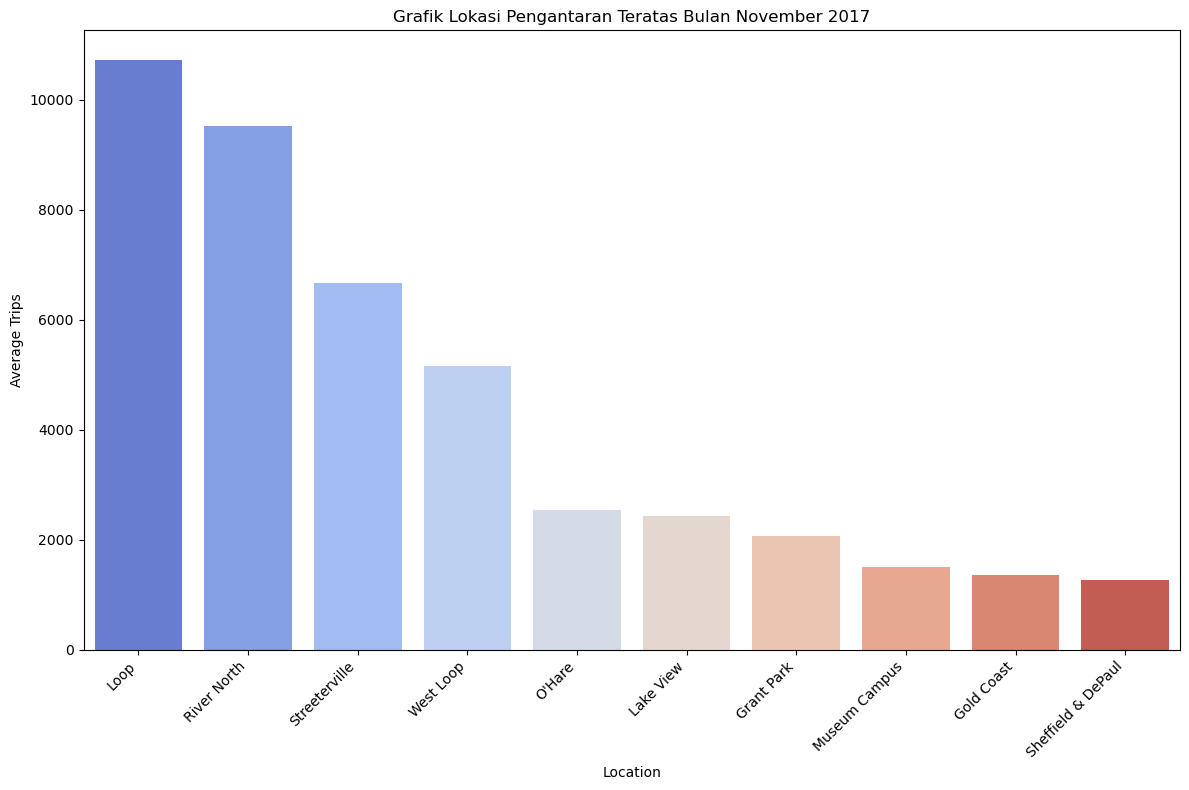

In [17]:
# grafik titik pengantaran favorit
plt.figure(figsize=(12,8))
sns.barplot(data=top_dropoff, x='dropoff_location_name', y='average_trips', palette='coolwarm')
plt.xlabel('Location')
plt.ylabel('Average Trips')
plt.title('Grafik Lokasi Pengantaran Teratas Bulan November 2017')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Pada grafik di atas, wilayah Loop menjadi titik pengantaran yang paling banyak perjalanan yang dilakukan oleh masyarakat pada bulan November 2017. Dengan jumlah rata-rata perjalanan 10727. River North menjadi posisi kedua dan Streeterville menjadi posisi ketiga. Karena wilayah Loop terdapat rata-rata perjalanan paling tinggi, lebih baik jika meningkatkan dan memperbanyak pelayanan pada wilayah ini.

### Perusahaan Taksi Favorit

In [18]:
# identifikasi perjalanan perusahaan taksi
top_comp = df1.sort_values('trips_amount', ascending=False).head(10)
top_comp

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasin,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
5,Chicago Carriage Cab Corp,9181
6,City Service,8448
7,Sun Taxi,7701
8,Star North Management LLC,7455
9,Blue Ribbon Taxi Association Inc.,5953


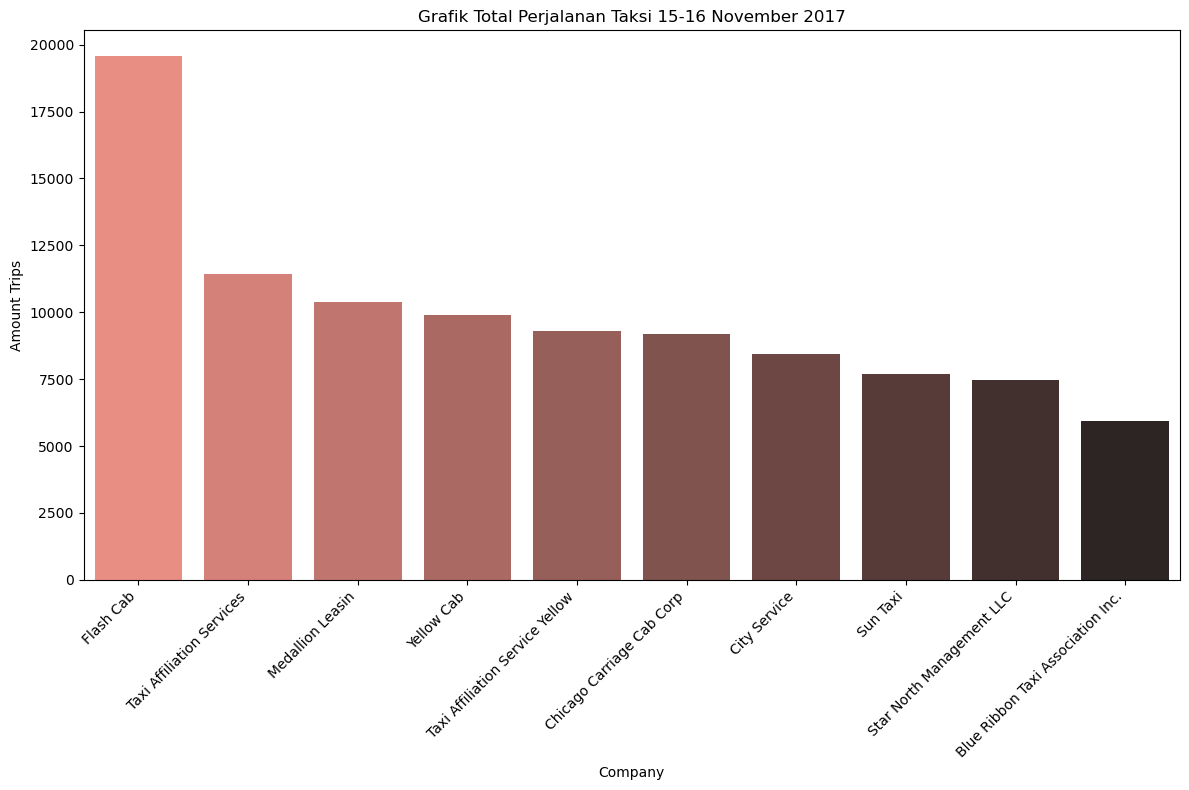

In [19]:
# grafik perjalanan perusahaan taksi
plt.figure(figsize=(12,8))
sns.barplot(data=top_comp, x='company_name', y='trips_amount', palette='dark:salmon_r')
plt.xlabel('Company')
plt.ylabel('Amount Trips')
plt.title('Grafik Total Perjalanan Taksi 15-16 November 2017')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Pada grafik di atas dapat ditarik beberapa kesimpulan yaitu:
- Perusahaan taksi Flash Cab menjadi perusahaan taksi yang paling banyak digunakan pada tanggal 15-16 November 2017 dengan total perjalanan 19558.
- Perusahaan Flash Cab memiliki total perjalanan hampir dua kali lipat dari total perjalanan perusahaan Taxi Affiliation Services yang hanya mempunyai 11422 total perjalanan.
- Perusahaan taksi seperti Flash Cab memiliki peran penting dalam industri transportasi di Chicago selama periode tersebut, dan mungkin memiliki basis pelanggan yang besar atau layanan yang diminati oleh penumpang.

## Analisis Data Statistik
Tahap ini akan diuji hipotesis terhadap data yang memuat perjalanan dari wilayah Loop menuju Bandara Internasional O'hare. Pengambilan data berasal dari data perjalanan yaitu trips dan data cuaca yaitu weather_records berasal dari kueri terakhir. File ini memuat data perjalanan dari Loop ke Bandara Internasional O'Hare. Ingat, berikut adalah nilai kolom-kolom yang ada di tabel ini:
- start_ts -- tanggal dan waktu penjemputan
- weather_conditions -- kondisi cuaca saat perjalanan dimulai
- duration_seconds -- durasi perjalanan dalam satuan detik

### Pra-pemrosesan Data

In [20]:
# Memuat dataset 1
try:
    df3 = pd.read_csv(
        r'C:\Users\Adam\OneDrive\Course\TripleTen\Sprint 6\moved_project_sql_result_07.csv', 
    )
    
except:
    df3 = pd.read_csv(
        '/datasets/moved_project_sql_result_07.csv'
    )

In [21]:
# menampilkan informasi umum dataset
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB


In [22]:
# menampilkan sampel dataset
df3.sample(10)

,start_ts,weather_conditions,duration_seconds
919,2017-11-04 06:00:00,Good,1519.0
166,2017-11-18 16:00:00,Bad,2340.0
924,2017-11-18 18:00:00,Good,1800.0
230,2017-11-11 09:00:00,Good,1380.0
991,2017-11-11 04:00:00,Good,1380.0
1025,2017-11-04 07:00:00,Good,1380.0
303,2017-11-18 14:00:00,Good,3780.0
258,2017-11-18 14:00:00,Good,2994.0
806,2017-11-11 09:00:00,Good,1359.0
387,2017-11-11 06:00:00,Good,1380.0


Pada dataset ini, terdapat 1068 baris yang utuh yang berarti tidak terdapat nilai yang hilang serta terdapat tiga kolom yaitu kolom start_ts yang memuat tanggal dan waktu perjalanan di hari Sabtu yang dibulatkan dalam satuan jam, kolom weather_conditions yang memuat kategori cuaca, dan kolom duration_seconds yang memuat durasi setiap perjalanan. 

Pada dataset tersebut, terdapat beberapa masalah seperti tipe data yang tidak sesuai pada kolom start_ts yang seharusnya tipe data datetime dan duration_seconds tipe data int. Untuk itu, sebelum dilakukan uji statistik, perlu diubah menjadi tipe data yang sesuai.

In [23]:
# memperbaiki tipe data pada dataset
df3['start_ts'] = pd.to_datetime(df3['start_ts'])
df3['duration_seconds'] = df3['duration_seconds'].astype(int)

In [24]:
# memeriksa tipe data 
df3.dtypes

start_ts              datetime64[ns]
weather_conditions            object
duration_seconds               int32
dtype: object

### Uji Hipotesis

Uji hipotesis ini bertujuan untuk mencari tahu apakah durasi rata-rata perjalanan dari Loop ke Bandara Internasional O'Hare tidak berubah saat hujan di hari Sabtu. Pengujian statistik yang cocok untuk menguji hipotesis ini adalah independent two-sample t-test (uji t dua sampel independen), karena saat ini ingin membandingkan dua kelompok independen. Hipotesis yang diajukan adalah:
- Hipotesis Nol (H0): Durasi rata-rata perjalanan dari Loop ke Bandara Internasional O'Hare tidak berubah saat hujan di hari Sabtu.
- Hipotesis Alternatif (H1): Durasi rata-rata perjalanan dari Loop ke Bandara Internasional O'Hare berubah saat hujan di hari Sabtu.

Dengan tingkat kepercayaan 95%, maka menggunakan alpha 5% = 0.05. Hipotesis Nol akan ditolak apabila alpha lebih besar dari uji statistik yaitu: Alpha > p_value

In [25]:
# memisahkan data cuaca 
rain_df = df3.query('weather_conditions == "Bad"').reset_index()
good_df = df3.query('weather_conditions == "Good"').reset_index()

# batas alpha
alpha = 0.05

In [26]:
# menampilkan rata-rata durasi dari kedua data
df3_mean = pd.pivot_table(df3, index='weather_conditions', values='duration_seconds', aggfunc='mean').reset_index()
df3_mean['mean_minutes'] = round(df3_mean['duration_seconds'] / 60).astype(int)
df3_mean

,weather_conditions,duration_seconds,mean_minutes
0,Bad,2427.205556,40
1,Good,1999.675676,33


Pada tabel di atas dapat diketahui bahwa rata-rata durasi perjalanan pada kondisi cuaca buruk memakan banyak waktu yaitu sekitar 40 menit, sedangkan untuk cuaca cerah mempunyai durasi perjalanan lebih singkat yaitu sekitar 33 menit.

Sebelum melakukan uji-t, lakukan uji homegenitas terlebih dahulu dengan hipotesis:
- Hipotesis Nol (H0) : Varians dua sample sama.
- Hipotesis Alternatif (H1) : Varians dua sample tidak sama.

In [27]:
# Uji homogenitas varians
homogenitas = st.levene(rain_df['duration_seconds'], good_df['duration_seconds']).pvalue

if homogenitas < alpha:
    conclusion = "Hipotesis nol ditolak. Terdapat perbedaan varians dari kedua sample"
else:
    conclusion = "Hipotesis nol diterima. Tidak terdapat perbedaan varians dari kedua sample"
conclusion

'Hipotesis nol diterima. Tidak terdapat perbedaan varians dari kedua sample'

In [28]:
# Menampilkan hasil uji homogenitas
homogenitas

0.5332038671974493

Nilai uji homogenitas sebesar 53.3% dan hipotesis menunjukkan bahwa varians dari kedua sampel adalah sama.

In [29]:
# Uji t-test
p_value = st.ttest_ind(rain_df['duration_seconds'], good_df['duration_seconds']).pvalue

# Bandingkan nilai p dengan alpha
if p_value < alpha:
    conclusion = "Hipotesis nol ditolak. Terdapat perbedaan signifikan pada rata-rata durasi perjalanan."
else:
    conclusion = "Hipotesis nol diterima. Tidak ada perbedaan signifikan pada rata-rata durasi perjalanan."

conclusion

'Hipotesis nol ditolak. Terdapat perbedaan signifikan pada rata-rata durasi perjalanan.'

In [30]:
# Menampilkan hasil uji-t
p_value

6.517970327099473e-12

Karena nilai uji statistik lebih kecil dari alpha, maka hipotesis nol ditolak. Hal ini membuktikan bahwa terdapat perbedaan yang signifikan dalam durasi rata-rata perjalanan antara perjalanan dari Loop ke Bandara Internasional O'Hare saat hujan dan saat kondisi cuaca cerah di hari Sabtu. Artinya, cuaca memiliki pengaruh yang signifikan terhadap durasi perjalanan, dengan durasi perjalanan cenderung lebih lama saat hujan.

## Kesimpulan

Kesimpulan dari analisis ini yaitu:
- Loop adalah wilayah yang paling banyak menjadi tujuan perjalanan pada bulan November 2017, dengan rata-rata perjalanan sekitar 10,727. Ini menunjukkan bahwa Loop adalah wilayah yang sangat diminati oleh masyarakat untuk perjalanan taksi, dan ada potensi menguntungkan bila meningkatkan layanan di wilayah ini.
- Flash Cab adalah perusahaan taksi yang paling banyak digunakan selama periode tersebut, dengan total perjalanan mencapai 19,558. Fakta bahwa Flash Cab memiliki jumlah perjalanan hampir dua kali lipat dari perusahaan taksi lain menunjukkan popularitasnya di Chicago selama tanggal 15-16 November 2017.
- Analisis terhadap cuaca menunjukkan bahwa durasi rata-rata perjalanan lebih lama sekitar 40 menit saat cuaca buruk dibandingkan dengan cuaca cerah sekitar 33 menit. Hasil uji statistik juga menegaskan bahwa perbedaan ini signifikan secara statistik. Dengan kata lain, cuaca memiliki pengaruh yang nyata terhadap durasi perjalanan, dengan perjalanan cenderung lebih lama saat hujan di hari Sabtu.

## Rekomendasi Bisnis
Dengan beberapa kesimpulan di atas, Zuber dapat:
- Dengan memfokuskan pengembangan dan peningkatan layanan di wilayah Loop—yang memiliki permintaan tertinggi—Zuber dapat menarik lebih banyak pelanggan, terutama pada hari Sabtu.
- Pengaruh cuaca terhadap durasi perjalanan memberikan peluang bagi Zuber untuk membedakan diri dengan layanan yang lebih responsif dan andal pada hari-hari dengan cuaca buruk, mengatasi kendala yang mungkin dialami oleh kompetitor seperti Flash Cab.